In [1]:
# Diabetic Foot Ulcer Segmentation

In [2]:
# lets get the data from here:
# https://github.com/uwm-bigdata/wound-segmentation/tree/master/data/Foot%20Ulcer%20Segmentation%20Challenge

In [3]:
# stdlib
import os
from pathlib import Path
from typing import Callable
from typing import List

# third party
from PIL import Image
from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import fit_flat_cos
from fastai.callback.schedule import lr_find
from fastai.data.block import DataBlock
from fastai.data.external import URLs
from fastai.data.external import untar_data
from fastai.data.transforms import FuncSplitter
from fastai.data.transforms import Normalize
from fastai.data.transforms import get_image_files
from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger
from fastai.torch_core import tensor
from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage
from fastai.vision.core import PILMask
from fastai.vision.data import ImageBlock
from fastai.vision.data import MaskBlock
from fastai.vision.data import imagenet_stats
from fastai.vision.learner import unet_learner
from fastcore.xtras import Path
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.models.resnet import resnet18
from torchvision.models.resnet import resnet34

In [4]:
data_dir = Path("../data")

In [5]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir, exist_ok=True)

In [6]:
os.listdir(data_dir)

['wound-segmentation']

In [7]:
# !pip install gitpython

In [8]:
def download_data():
    import git
    git.Git(data_dir).clone("https://github.com/uwm-bigdata/wound-segmentation")

In [9]:
if "wound-segmentation" not in os.listdir(data_dir):
    download_data()

In [10]:
dfu_dataset_path = data_dir / "wound-segmentation" / "data" / "Foot Ulcer Segmentation Challenge"

In [11]:
dfu_dataset_path

Path('../data/wound-segmentation/data/Foot Ulcer Segmentation Challenge')

In [12]:
os.listdir(dfu_dataset_path)

['FootUlcerSegmentationChallenge2021.pdf',
 'README.MD',
 'train',
 'test',
 'validation']

In [13]:
train_path = dfu_dataset_path / "train"
train_image_path = train_path / "images"
train_image_labels = train_path / "labels"

val_path = dfu_dataset_path / "validation"
val_image_path = val_path / "images"
val_image_labels = val_path / "labels"

test_image_path = dfu_dataset_path / "test" / "images"

In [14]:
train_images = get_image_files(train_image_path)
val_images = get_image_files(train_image_path)

In [15]:
# lets compare with CAMVID from:
# https://github.com/walkwithfastai/walkwithfastai.github.io/blob/master/nbs/course2020/vision/04_Segmentation.ipynb

<AxesSubplot:>

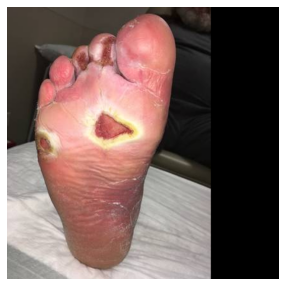

In [16]:
img_fn = train_images[0]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [17]:
get_msk = lambda o: o.parent.parent / 'labels' / f'{o.stem}{o.suffix}'

<AxesSubplot:>

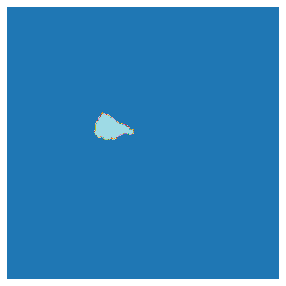

In [18]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

<AxesSubplot:>

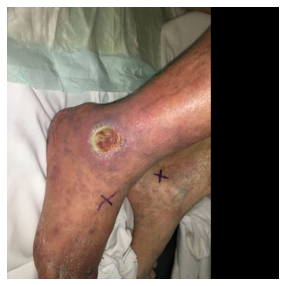

In [19]:
img_fn = train_images[1]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

<AxesSubplot:>

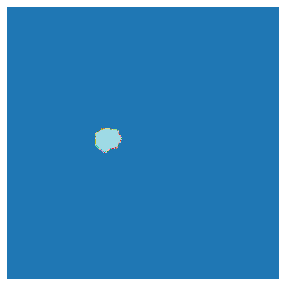

In [20]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [21]:
tensor(msk)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [22]:
np.unique(tensor(msk), return_counts=True)

(array([  0, 255], dtype=uint8), array([260486,   1658]))

In [23]:
# looks like 0 is void and 255 is wound

In [24]:
def is_valid() -> Callable:
    def _func(x): return "/validation/" in str(x)
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [25]:
trainval = train_images + val_images
def all_data(path) -> List[Path]:
    return trainval

In [26]:
sz = msk.shape; sz

(512, 512)

In [27]:
half = tuple(int(x/2) for x in sz); half

(256, 256)

In [28]:
# CamVid is (360, 480)

In [29]:
dfu = DataBlock(
    blocks=(ImageBlock, MaskBlock()),
    get_items=all_data,
    splitter=is_valid(),
    get_y=get_msk,
    batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)]
)

In [30]:
dls = dfu.dataloaders(None, bs=8)

/home/madhavajay/fastbook/.venv/lib/python3.10/site-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


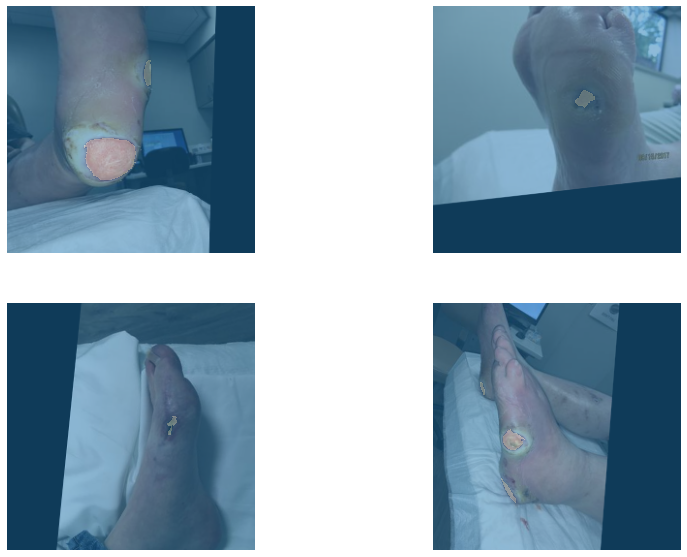

In [31]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [32]:
codes = ["Void", "Wound"]

In [33]:
dls.vocab = codes

In [34]:
name2id = {"Void":0, "Wound":255}

In [35]:
name2id

{'Void': 0, 'Wound': 255}

In [36]:
void_code = name2id["Void"]

In [37]:
void_code

0

In [38]:
def acc_dfu(inp, targ):
    print("acc_dfu", type(inp), type(targ))
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [39]:
opt = ranger

In [40]:
dls.vocab = codes
learn = unet_learner(dls, resnet34, metrics=acc_dfu, self_attention=True, act_cls=Mish, opt_func=opt)
# learn.load('model_1')

In [41]:
learn.lr_find()

../aten/src/ATen/native/cuda/Loss.cu:257: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [11,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

In [ ]:
lr = 1e-3

In [ ]:
learn.fit_flat_cos(10, slice(lr))